# Installing of the Dataset from Kaggle
- downloading the Brats 2018 dataset from kaggle
- unzip the brats dataset

In [ ]:
 
 ! pip install -q kaggle
 from google.colab import files
 files.upload()
 !mkdir ~/.kaggle
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json
 ! kaggle datasets download -d sanglequang/brats2018 
!unzip brats2018.zip -d brats2018

Saving kaggle.json to kaggle.json
100% 3.17G/3.18G [00:26<00:00, 117MB/s]
100% 3.18G/3.18G [00:26<00:00, 127MB/s]
Archive:  brats2018.zip
  inflating: brats2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_flair.nii  
  inflating: brats2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_seg.nii  
  inflating: brats2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t1.nii  
  inflating: brats2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t1ce.nii  
  inflating: brats2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t2.nii  
  inflating: brats2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_11_1/Brats18_2013_11_1_flair.nii  
  inflating: brats2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_11_1/Brats18_2013_11_1_seg.nii  
  inflating: brats2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_11_1/Brats18_2013_11_1_t1.nii  
  inflating: brats20

Installing python libraries

In [ ]:
! pip install split-folders segmentation_models_3D mindspore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 142.7 MB 2.2 MB/s 
     |████████████████████████████████| 50 kB 6.0 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 281 kB 45.9 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


# Importing all required python packages

In [ ]:
import numpy as np
import nibabel as nib
import glob
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import random

# Getting our dataset ready

To normalize the dicom image to make intensity of the image uniform

In [ ]:
# Normalization

scaler = MinMaxScaler()
import cv2

In [ ]:
# List of all the nii training images

t2_list = sorted(glob.glob('/content/brats2018/MICCAI_BraTS_2018_Data_Training/*/*/*t2.nii'))
t1ce_list = sorted(glob.glob('/content/brats2018/MICCAI_BraTS_2018_Data_Training/*/*/*t1ce.nii'))
flair_list = sorted(glob.glob('/content/brats2018/MICCAI_BraTS_2018_Data_Training/*/*/*flair.nii'))
t1_list = sorted(glob.glob('/content/brats2018/MICCAI_BraTS_2018_Data_Training/*/*/*t1.nii'))
mask_list = sorted(glob.glob('/content/brats2018/MICCAI_BraTS_2018_Data_Training/*/*/*seg.nii'))

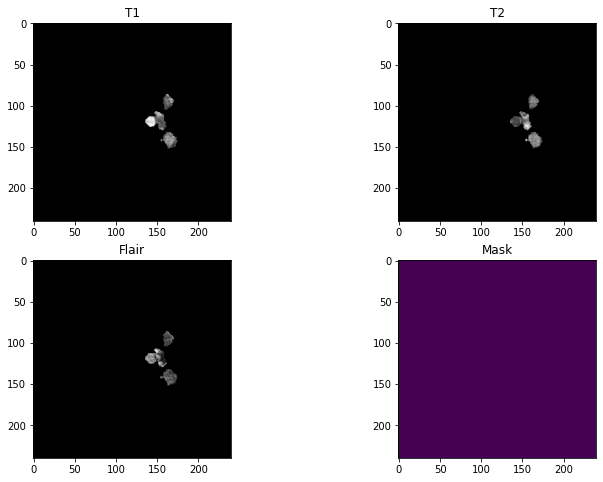

In [ ]:
# Plotting of nii images from Brats 2018 dataset

n_slice=random.randint(0, 155)
plt.figure(figsize=(12, 8))

n = random.randint(0,285)
t2=nib.load(t2_list[n]).get_fdata()
t1=nib.load(t1_list[n]).get_fdata()
flair=nib.load(flair_list[n]).get_fdata()
mask=nib.load(mask_list[n]).get_fdata()

plt.subplot(221)
plt.imshow(t1[:,:,n_slice], cmap='gray')
plt.title('T1')
plt.subplot(222)
plt.imshow(t2[:,:,n_slice], cmap='gray')
plt.title('T2')
plt.subplot(223)
plt.imshow(flair[:,:,n_slice], cmap='gray')
plt.title('Flair')
plt.subplot(224)
plt.imshow(mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
"""

Creating folders :
train128/img -> training images with shape (128,128,128)
train128/mask -> training mask with shape (128,128,128)
val128/img -> validation images with shape (128,128,128)

"""

from pathlib import Path
Path("./train128/img/").mkdir(parents=True, exist_ok=True)
Path("./train128/mask/").mkdir(parents=True, exist_ok=True)
Path("./val128/img/").mkdir(parents=True, exist_ok=True)

In [ ]:
# List of all the nii validation images

val_t2_list = sorted(glob.glob('/content/brats2018/MICCAI_BraTS_2018_Data_Validation/*/*t2.nii'))
val_t1ce_list = sorted(glob.glob('/content/brats2018/MICCAI_BraTS_2018_Data_Validation/*/*t1ce.nii'))
val_flair_list = sorted(glob.glob('/content/brats2018/MICCAI_BraTS_2018_Data_Validation/*/*flair.nii'))
val_t1_list = sorted(glob.glob('/content/brats2018/MICCAI_BraTS_2018_Data_Validation/*/*t1.nii'))

In [ ]:
"""
VALIDATION DATASET

1. Normalization of numpy array
2. Combining t1 , t1ce, t2, flair into one numpy
2. Croping the numpy array to (128,128,128)
3. Add 4 channels to the numpy array

"""

for img in tqdm(range(0,len(val_t2_list))):   #Using t1_list as all lists are of same size
      
    temp_image_t2=nib.load(val_t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(val_t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(val_flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

    temp_image_t1 = nib.load(val_t1_list[img]).get_fdata()
    temp_image_t1=scaler.fit_transform(temp_image_t1.reshape(-1, temp_image_t1.shape[-1])).reshape(temp_image_t1.shape)
        
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2,temp_image_t1], axis=3)
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]

    np.save('./val128/img/img_'+str(img)+'.npy', temp_combined_images)

100%|██████████| 66/66 [01:19<00:00,  1.20s/it]


In [ ]:
"""
TRAINING DATASET

1. Normalization of numpy array
2. Combining t1 , t1ce, t2, flair into one numpy
2. Croping the numpy array to (128,128,128)
3. Add 4 channels to the numpy array

"""

for img in tqdm(range(0,len(t2_list))):   #Using t1_list as all lists are of same size
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

    temp_image_t1 = nib.load(t1_list[img]).get_fdata()
    temp_image_t1=scaler.fit_transform(temp_image_t1.reshape(-1, temp_image_t1.shape[-1])).reshape(temp_image_t1.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2,temp_image_t1], axis=3)
    # print(type(temp_mask))
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True)

    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        temp_mask= to_categorical(temp_mask, num_classes=4)
        # print(type(temp_mask))
        np.save('./train128/img/img_'+str(img)+'.npy', temp_combined_images)
        np.save('./train128/mask/mask_'+str(img)+'.npy', temp_mask)
        
    else:
        print("Discard data") 

  1%|▏         | 4/285 [00:06<07:10,  1.53s/it]

Discard data


  5%|▍         | 14/285 [00:24<07:38,  1.69s/it]

Discard data


  9%|▉         | 25/285 [00:42<06:54,  1.59s/it]

Discard data


 17%|█▋        | 48/285 [01:23<06:28,  1.64s/it]

Discard data


 20%|█▉        | 56/285 [01:37<06:29,  1.70s/it]

Discard data


 22%|██▏       | 64/285 [01:51<06:19,  1.72s/it]

Discard data


 28%|██▊       | 81/285 [02:21<05:33,  1.64s/it]

Discard data


 29%|██▉       | 83/285 [02:24<05:16,  1.57s/it]

Discard data


 35%|███▍      | 99/285 [02:53<05:14,  1.69s/it]

Discard data


 36%|███▌      | 102/285 [02:58<05:04,  1.67s/it]

Discard data


 37%|███▋      | 106/285 [03:05<04:47,  1.61s/it]

Discard data


 44%|████▎     | 124/285 [03:37<04:36,  1.72s/it]

Discard data


 52%|█████▏    | 149/285 [04:23<03:46,  1.67s/it]

Discard data


 60%|██████    | 172/285 [05:05<03:22,  1.79s/it]

Discard data


 64%|██████▍   | 183/285 [05:24<02:44,  1.61s/it]

Discard data


 75%|███████▌  | 214/285 [06:19<01:57,  1.66s/it]

Discard data


 81%|████████  | 231/285 [06:49<01:31,  1.70s/it]

Discard data


 92%|█████████▏| 261/285 [07:42<00:40,  1.70s/it]

Discard data


 95%|█████████▌| 271/285 [07:59<00:22,  1.59s/it]

Discard data


 99%|█████████▉| 283/285 [08:21<00:03,  1.78s/it]

Discard data


100%|██████████| 285/285 [08:25<00:00,  1.77s/it]


In [ ]:
"""

Splitting the train128 folder into :
- training_data/train
- training_data/val

"""

import splitfolders

input_folder = './train128/'
output_folder = './training_data'
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None)

Copying files: 530 files [03:08,  2.81 files/s]


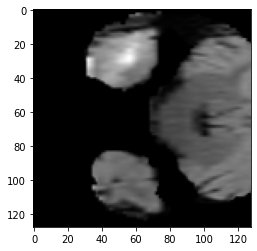

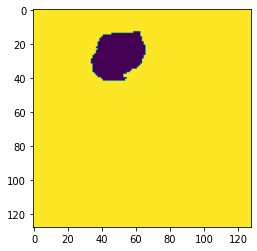

In [ ]:
# Plotting data from our new dataset

n = random.randint(0,128)
img = np.load('./training_data/train/img/img_0.npy')
mask = np.load('./training_data/train/mask/mask_0.npy')
plt.imshow(img[:,:,n,0],cmap='gray')
plt.show()
plt.imshow(mask[:,:,n,0])
plt.show()

# Data Generator

In [ ]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)

In [ ]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [ ]:
# Training Data Genarator

batch_size = 2
train_img_dir = "./training_data/train/img/"
train_mask_dir = "./training_data/train/mask/"
train_img_list=sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))
train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)


In [ ]:
# Validation Data Genarator

val_img_dir = "./training_data/val/mask/"
val_mask_dir = "./training_data/val/mask/"
val_img_list=sorted(os.listdir(val_img_dir))
val_mask_list=sorted(os.listdir(val_mask_dir))
val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

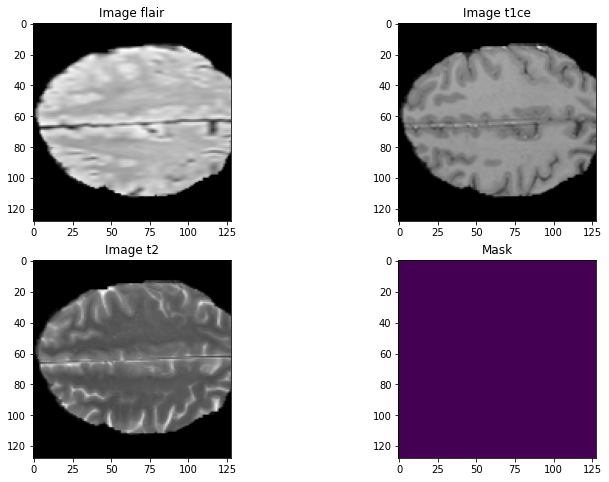

In [ ]:
# Plotting from the train data genarator

img, msk = train_img_datagen.__next__()


img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
"""

Calculating the weight of different labels
Labels : 
{
  0: not tumor
  1: necrotic and non-enhancing tumor core,
  2: peritumoral edema,
  3: enhancing tumor
}
"""


import pandas as pd
columns = ['0','1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('./training_data/*/*/*.npy'))
for img in range(len(train_mask_list)):
    temp_image=np.load(train_mask_list[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)
    
    df = df.append(conts_dict, ignore_index=True)

label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['2'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4
weights = []
#Class weights claculation: n_samples / (n_classes * n_samples_for_class)
weights.append(round((total_labels/(n_classes*label_0)), 2)) #round to 2 decimals
weights.append(round((total_labels/(n_classes*label_1)), 2))
weights.append(round((total_labels/(n_classes*label_2)), 2))
weights.append(round((total_labels/(n_classes*label_3)), 2))
 
#bring the weight between 0 to 1 

wt0 = (weights[0] - min(weights))/(max(weights)-min(weights))
wt1 = (weights[1] - min(weights))/(max(weights)-min(weights))
wt2 = (weights[2] - min(weights))/(max(weights)-min(weights))
wt3 = (weights[3] - min(weights))/(max(weights)-min(weights))

In [ ]:
# Importing libraries for building the UNET Model 

import segmentation_models_3D as sm
import keras.backend as K
import tensorflow as tf
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

Segmentation Models: using `tf.keras` framework.


In [ ]:
# Custom Metrics for UNET Model 

def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5),dice_coef]

In [ ]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [ ]:
kernel_initializer =  'he_uniform'

# VGG Model

In [ ]:
from keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D,Flatten ,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU

In [ ]:
def vgg_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(filters=64, kernel_size=(3, 3,3), padding='same', activation='relu')(s)
    c1 = Conv3D(filters=64, kernel_size=(3, 3,3), padding='same', activation='relu')(c1)
    outputs = Dense(4, activation='softmax', name='output')(c1)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    model.summary()
    
    return model

#Test if everything is working ok. 
model = vgg_model(128,128,128,4,4)
print(model.input_shape)
print(model.output_shape)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 128, 4  0         
                             )]                                  
                                                                 
 conv3d (Conv3D)             (None, 128, 128, 128, 64  6976      
                             )                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 128, 128, 128, 64  110656    
                             )                                   
                                                                 
 output (Dense)              (None, 128, 128, 128, 4)  260       
                                                                 
Total params: 117,892
Trainable params: 117,892
Non-trainable params: 0
_______________________________________________________

# Training VGG Model

In [ ]:
model = vgg_model(128,128,128,4,4)

model.compile(optimizer = optim, loss=total_loss
              , metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 128, 4  0         
                             )]                                  
                                                                 
 conv3d_2 (Conv3D)           (None, 128, 128, 128, 64  6976      
                             )                                   
                                                                 
 conv3d_3 (Conv3D)           (None, 128, 128, 128, 64  110656    
                             )                                   
                                                                 
 output (Dense)              (None, 128, 128, 128, 4)  260       
                                                                 
Total params: 117,892
Trainable params: 117,892
Non-trainable params: 0
_____________________________________________________

In [ ]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

model.save('vgg16_brats18.hdf5')

Epoch 1/100
99/99 [==============================] - 148s 1s/step - loss: 1.0151 - accuracy: 0.9305 - iou_score: 0.1149 - dice_coef: 0.4586 - val_loss: 1.0229 - val_accuracy: 0.9543 - val_iou_score: 0.0136 - val_dice_coef: 0.4281
Epoch 2/100
99/99 [==============================] - 223s 2s/step - loss: 0.9828 - accuracy: 0.9507 - iou_score: 0.2233 - dice_coef: 0.6998 - val_loss: 1.0508 - val_accuracy: 0.9526 - val_iou_score: 0.0157 - val_dice_coef: 0.3358
Epoch 3/100
99/99 [==============================] - 217s 2s/step - loss: 0.9432 - accuracy: 0.9489 - iou_score: 0.3089 - dice_coef: 0.8625 - val_loss: 1.0665 - val_accuracy: 0.0812 - val_iou_score: 0.0250 - val_dice_coef: 0.2990
Epoch 4/100
99/99 [==============================] - 217s 2s/step - loss: 0.9243 - accuracy: 0.9429 - iou_score: 0.3328 - dice_coef: 0.8712 - val_loss: 1.0690 - val_accuracy: 0.0815 - val_iou_score: 0.0254 - val_dice_coef: 0.3132
Epoch 5/100
99/99 [==============================] - 217s 2s/step - loss: 0.9170

221s 2s/step - loss: -1.2890 - accuracy: 0.9457 - iou_score: 0.4001 - dice_coef: 0.9435 - val_loss: 0.9659 - val_accuracy: 0.9543 - val_iou_score: 0.2461 - val_dice_coef: 0.9459

# Plotting

Text(0.5, 0, 'Epoch')

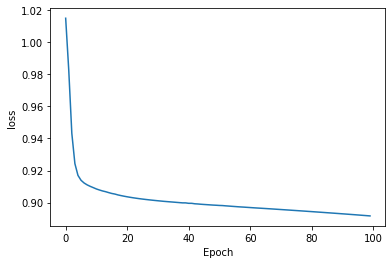

In [ ]:
plt.plot(history.history['loss'])
plt.ylabel('Training loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

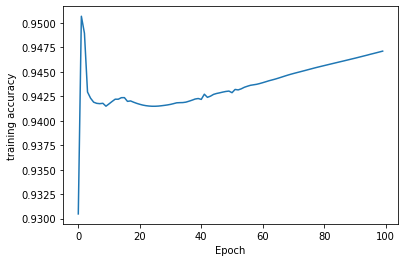

In [ ]:
plt.plot(history.history['accuracy'])
plt.ylabel('training accuracy')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

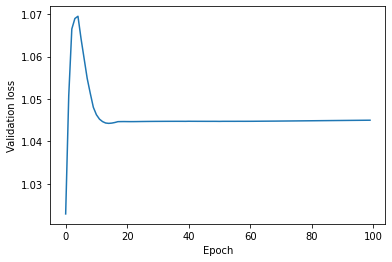

In [ ]:
plt.plot(history.history['val_loss'])
plt.ylabel('Validation loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

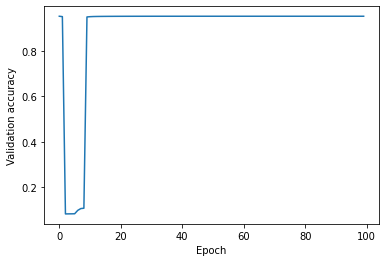

Text(0.5, 0, 'Epoch')

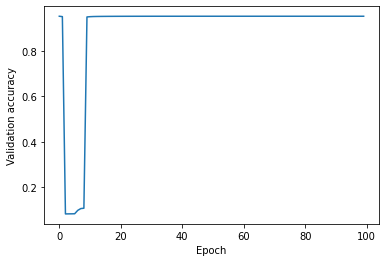

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.ylabel('Validation accuracy')
plt.xlabel('Epoch')

In [ ]:
from keras.models import load_model

In [ ]:
my_model = my_model = load_model('vgg16_brats18.hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5),'dice_coef':dice_coef})

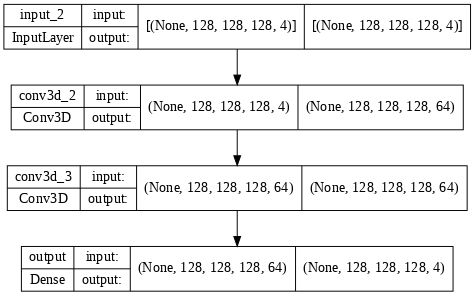

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(my_model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [ ]:
history2=my_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=1,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

99/99 [==============================] - 218s 2s/step - loss: 0.8917 - accuracy: 0.9468 - iou_score: 0.3961 - dice_coef: 0.9356 - val_loss: 1.0450 - val_accuracy: 0.9543 - val_iou_score: 0.2461 - val_dice_coef: 0.9071


In [ ]:
# Hausdroff Distance

from mindspore import nn, Tensor

def hausdroff_dist(y_true,y_pred):
    metric = nn.HausdorffDistance()
    metric.clear()
    metric.update(y_true, y_pred, 0)
    mean_average_distance = metric.eval()
    return mean_average_distance.tolist()

In [ ]:
image  = sorted(glob.glob('/content/train128/img/*.npy'))
len(image)

### Average Hausdroff Distance

In [ ]:
dist_list = []
for i in range(0,200):
  img, msk = train_img_datagen.__next__()
  img_num = random.randint(0,img.shape[0]-1)
  test_img=img[img_num]
  test_mask=msk[img_num]
  test_mask_argmax=np.argmax(test_mask, axis=3)
  test_img_input = np.expand_dims(test_img, axis=0)
  test_prediction = my_model.predict(test_img_input)
  test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]
  dist_list.append(hausdroff_dist(test_mask_argmax[:,:,n_slice],test_prediction_argmax[:,:, n_slice]))

print("[Average Hausdroff Distance] : " + str(sum(dist_list) / len(dist_list)))

[Average Hausdroff Distance] : 34.5297482844153


## Plotting LGG Images

In [ ]:
# List of LGG nii images

t2_list = sorted(glob.glob('/content/brats2018/MICCAI_BraTS_2018_Data_Training/HGG/*/*t2.nii'))
t1ce_list = sorted(glob.glob('/content/brats2018/MICCAI_BraTS_2018_Data_Training/HGG/*/*t1ce.nii'))
flair_list = sorted(glob.glob('/content/brats2018/MICCAI_BraTS_2018_Data_Training/HGG/*/*flair.nii'))
t1_list = sorted(glob.glob('/content/brats2018/MICCAI_BraTS_2018_Data_Training/HGG/*/*t1.nii'))
mask_list = sorted(glob.glob('/content/brats2018/MICCAI_BraTS_2018_Data_Training/HGG/*/*seg.nii'))

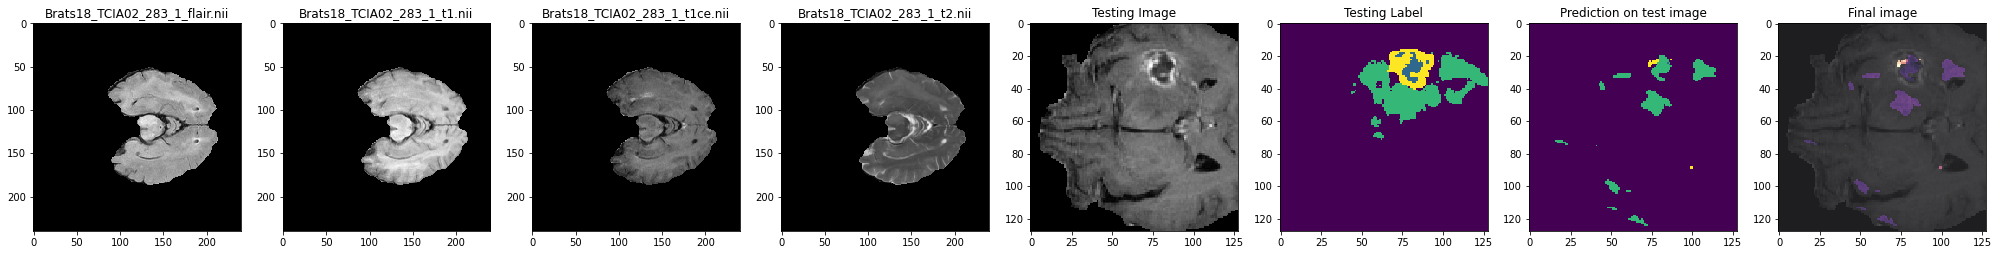

[Slide No] :55
[Hausdroff Distance] : 29.154759474226502


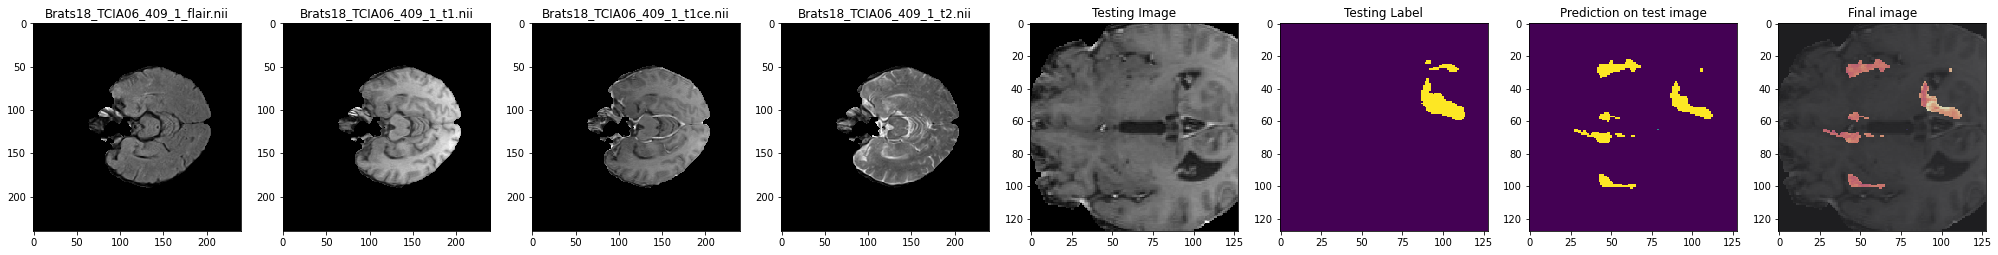

[Slide No] :55
[Hausdroff Distance] : 46.32493928760188


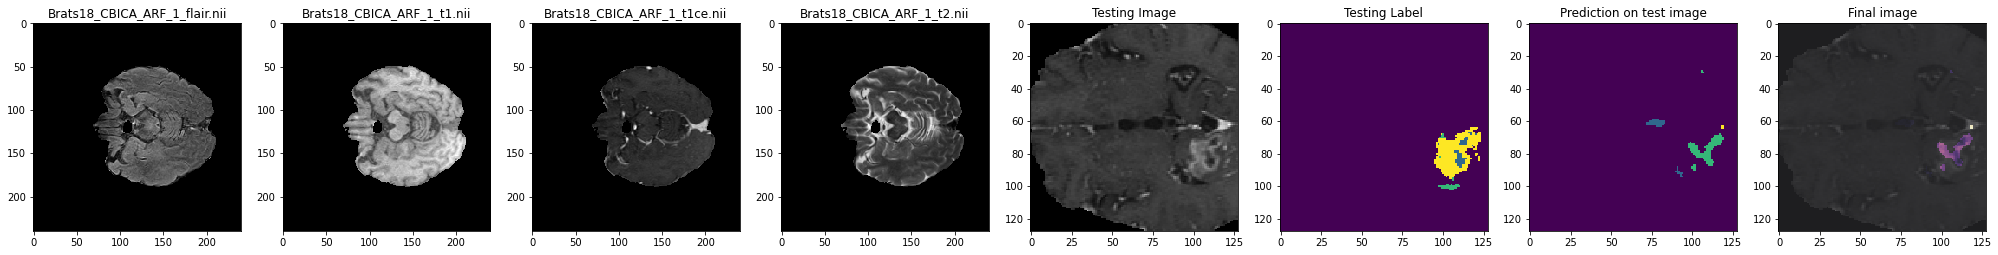

[Slide No] :55
[Hausdroff Distance] : 26.832815729997478


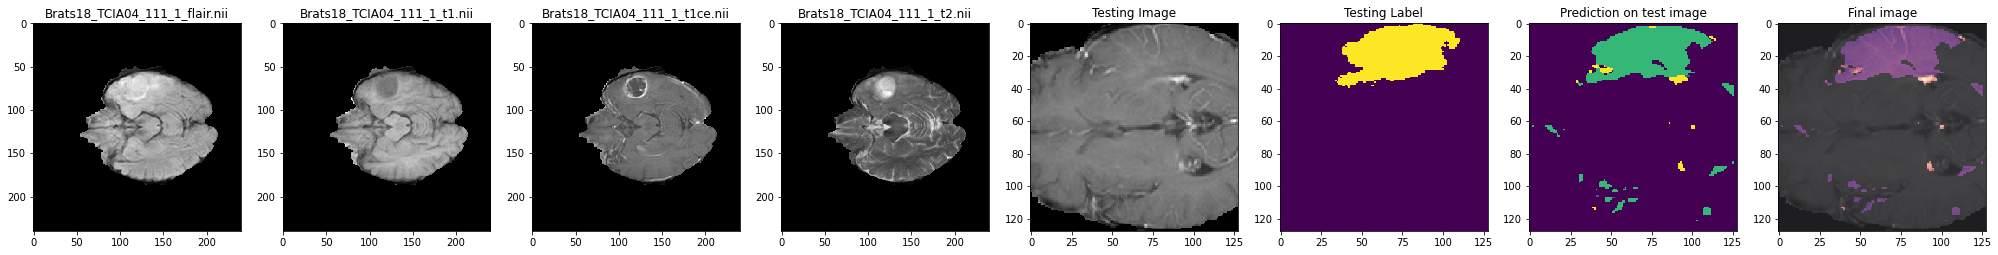

[Slide No] :55
[Hausdroff Distance] : 36.0


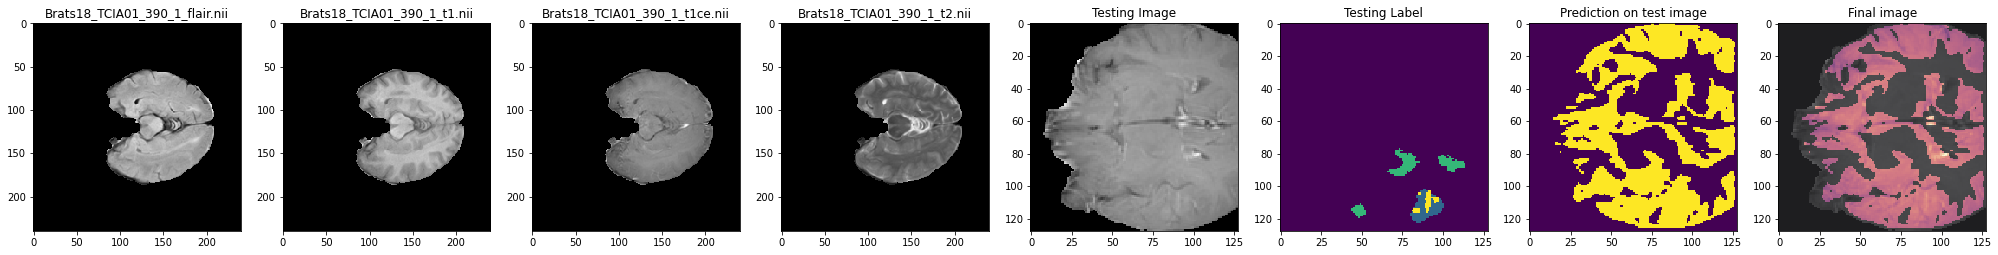

[Slide No] :55
[Hausdroff Distance] : 42.0


In [ ]:
for i in range(0,5):
  img = random.randint(0,len(mask_list))
  temp_image_t2=nib.load(t2_list[img]).get_fdata()
  temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
  
  temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
  temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
  
  temp_image_flair=nib.load(flair_list[img]).get_fdata()
  temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
  temp_image_t1 = nib.load(t1_list[img]).get_fdata()
  temp_image_t1=scaler.fit_transform(temp_image_t1.reshape(-1, temp_image_t1.shape[-1])).reshape(temp_image_t1.shape)

  temp_mask=nib.load(mask_list[img]).get_fdata()
  temp_mask=temp_mask.astype(np.uint8)
  temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
  temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2,temp_image_t1], axis=3)
  #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
  #cropping x, y, and z
  test_img=temp_combined_images[56:184, 56:184, 13:141]
  temp_mask = temp_mask[56:184, 56:184, 13:141]
  test_mask= to_categorical(temp_mask, num_classes=4)
  test_mask_argmax=np.argmax(test_mask, axis=3)
  test_img_input = np.expand_dims(test_img, axis=0)
  test_prediction = my_model.predict(test_img_input)
  test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]
  from matplotlib import pyplot as plt
  import random
  #n_slice=random.randint(0, test_prediction_argmax.shape[2])
  n_slice = 55
  plt.figure(figsize=(35, 50))
  plt.subplot(1, 8, 1)
  flair_name = flair_list[img].split('/')[6]  
  plt.title(f'{flair_name}')
  plt.imshow(temp_image_flair[:,:,n_slice],interpolation='none', cmap='gray')
  plt.subplot(1, 8, 2) 
  t1_name = t1_list[img].split('/')[6] 
  plt.title(f'{t1_name}')
  plt.imshow(temp_image_t1[:,:,n_slice],interpolation='none', cmap='gray')
  plt.subplot(1, 8, 3)  
  t1ce_name = t1ce_list[img].split('/')[6]
  plt.title(f'{t1ce_name}')
  plt.imshow(temp_image_t1ce[:,:,n_slice],interpolation='none', cmap='gray')
  plt.subplot(1, 8, 4)
  t2_name = t2_list[img].split('/')[6]  
  plt.title(f'{t2_name}')
  plt.imshow(temp_image_t2[:,:,n_slice],interpolation='none', cmap='gray')
  plt.subplot(1, 8, 5)  
  plt.title('Testing Image')
  plt.imshow(test_img[:,:,n_slice,1],interpolation='none', cmap='gray')
  plt.subplot(1, 8, 6)
  plt.title('Testing Label')
  plt.imshow(test_mask_argmax[:,:,n_slice],interpolation='none')
  plt.subplot(1, 8, 7)
  plt.title('Prediction on test image')
  plt.imshow(test_prediction_argmax[:,:, n_slice],interpolation='none')
  plt.subplot(1, 8, 8)
  plt.title('Final image')
  plt.imshow( test_img[:,:,n_slice,1] ,interpolation='none',cmap="gray",alpha=0.7)
  plt.imshow(test_img[:,:,n_slice,1]*test_prediction_argmax[:,:, n_slice],interpolation='none',cmap="magma",alpha=0.6)
  plt.show()
  print("[Slide No] :"+str(n_slice))
  print("[Hausdroff Distance] : " + str(hausdroff_dist(test_mask_argmax[:,:,n_slice],test_prediction_argmax[:,:, n_slice]) ) )


## Plotting of HGG Image

In [ ]:
# List of HGG nii images

t2_list = sorted(glob.glob('/content/brats2018/MICCAI_BraTS_2018_Data_Training/LGG/*/*t2.nii'))
t1ce_list = sorted(glob.glob('/content/brats2018/MICCAI_BraTS_2018_Data_Training/LGG/*/*t1ce.nii'))
flair_list = sorted(glob.glob('/content/brats2018/MICCAI_BraTS_2018_Data_Training/LGG/*/*flair.nii'))
t1_list = sorted(glob.glob('/content/brats2018/MICCAI_BraTS_2018_Data_Training/LGG/*/*t1.nii'))
mask_list = sorted(glob.glob('/content/brats2018/MICCAI_BraTS_2018_Data_Training/LGG/*/*seg.nii'))

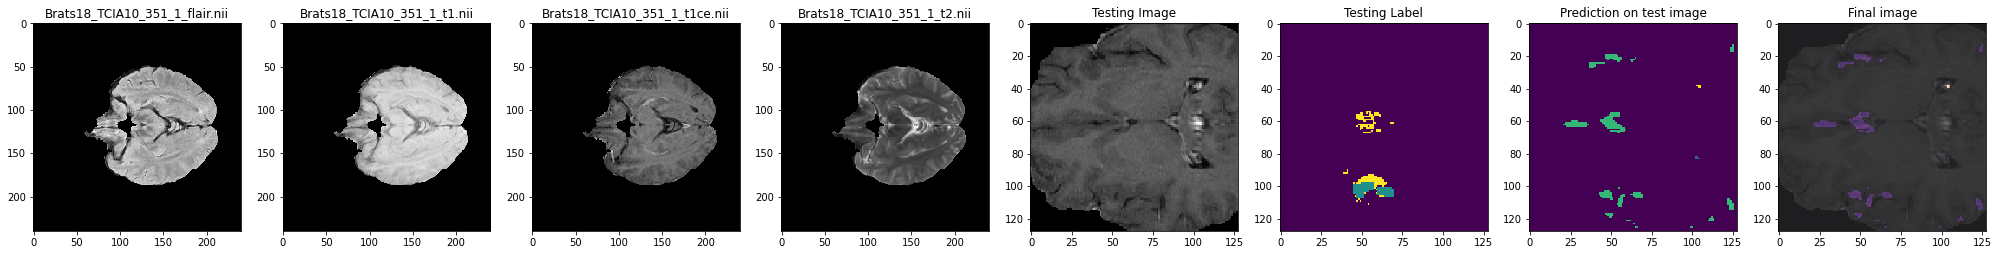

[Slide No] :55
[Hausdroff Distance] : 28.0


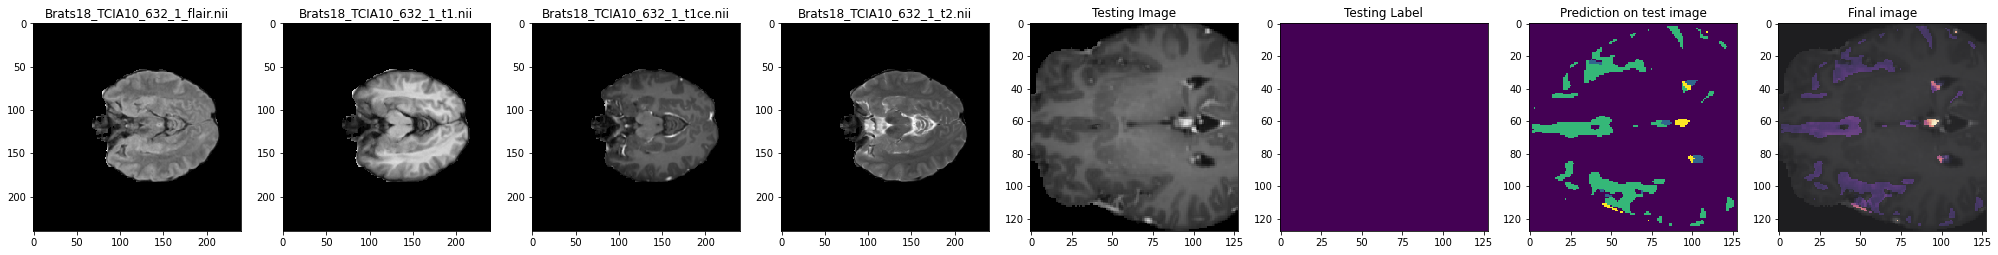

[Slide No] :55
[Hausdroff Distance] : 63.0


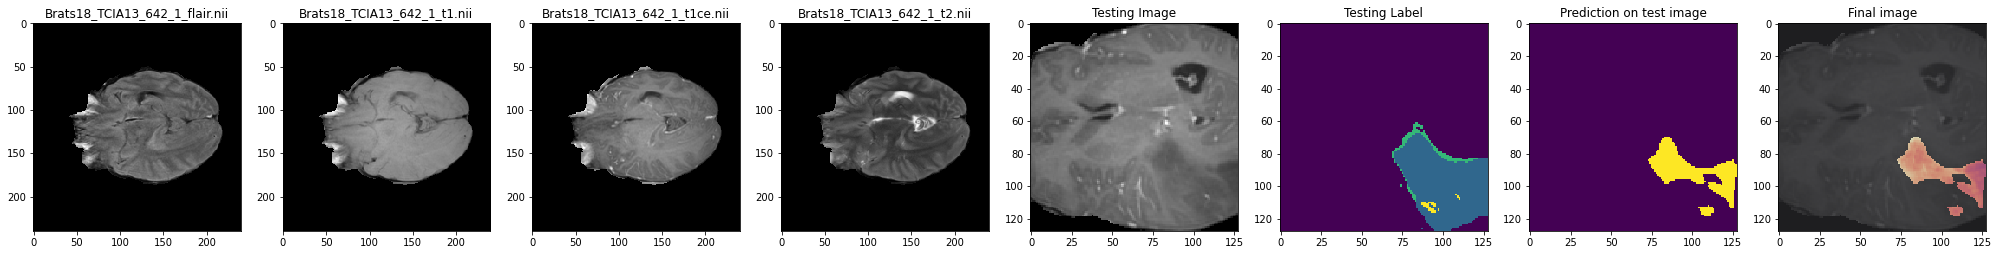

[Slide No] :55
[Hausdroff Distance] : 19.026297590440446


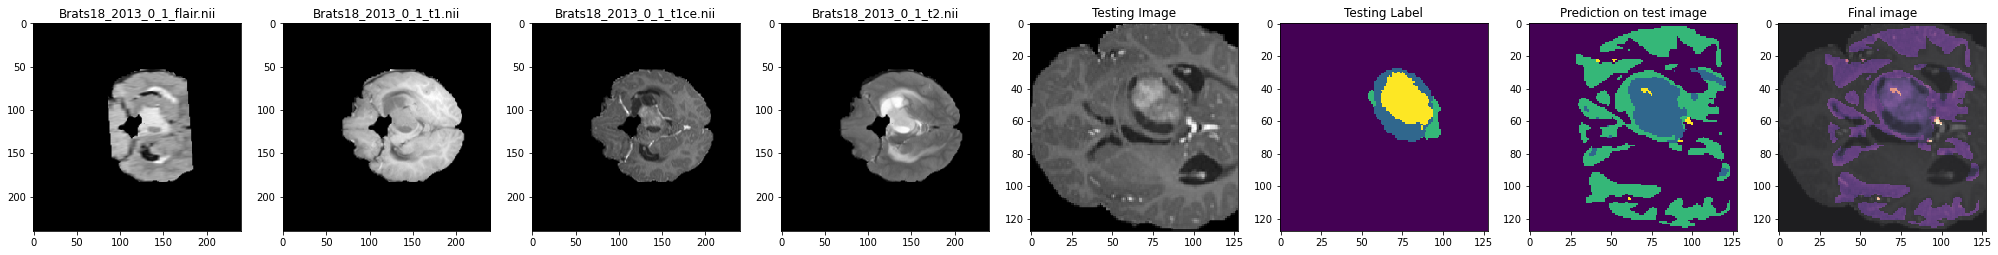

[Slide No] :55
[Hausdroff Distance] : 35.4682957019364


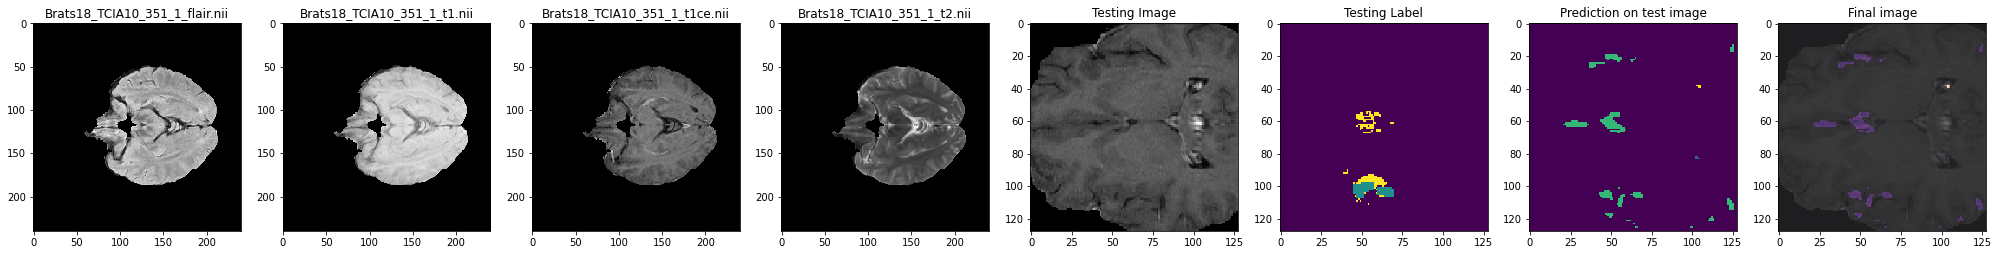

[Slide No] :55
[Hausdroff Distance] : 28.0


In [ ]:
for i in range(0,5):
  img = random.randint(0,len(mask_list))
  temp_image_t2=nib.load(t2_list[img]).get_fdata()
  temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
  
  temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
  temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
  
  temp_image_flair=nib.load(flair_list[img]).get_fdata()
  temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
  temp_image_t1 = nib.load(t1_list[img]).get_fdata()
  temp_image_t1=scaler.fit_transform(temp_image_t1.reshape(-1, temp_image_t1.shape[-1])).reshape(temp_image_t1.shape)

  temp_mask=nib.load(mask_list[img]).get_fdata()
  temp_mask=temp_mask.astype(np.uint8)
  temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
  temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2,temp_image_t1], axis=3)
  #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
  #cropping x, y, and z
  test_img=temp_combined_images[56:184, 56:184, 13:141]
  temp_mask = temp_mask[56:184, 56:184, 13:141]
  test_mask= to_categorical(temp_mask, num_classes=4)
  test_mask_argmax=np.argmax(test_mask, axis=3)
  test_img_input = np.expand_dims(test_img, axis=0)
  test_prediction = my_model.predict(test_img_input)
  test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]
  from matplotlib import pyplot as plt
  import random
  #n_slice=random.randint(0, test_prediction_argmax.shape[2])
  n_slice = 55
  plt.figure(figsize=(35, 50))
  plt.subplot(1, 8, 1)
  flair_name = flair_list[img].split('/')[6]  
  plt.title(f'{flair_name}')
  plt.imshow(temp_image_flair[:,:,n_slice],interpolation='none', cmap='gray')
  plt.subplot(1, 8, 2) 
  t1_name = t1_list[img].split('/')[6] 
  plt.title(f'{t1_name}')
  plt.imshow(temp_image_t1[:,:,n_slice],interpolation='none', cmap='gray')
  plt.subplot(1, 8, 3)  
  t1ce_name = t1ce_list[img].split('/')[6]
  plt.title(f'{t1ce_name}')
  plt.imshow(temp_image_t1ce[:,:,n_slice],interpolation='none', cmap='gray')
  plt.subplot(1, 8, 4)
  t2_name = t2_list[img].split('/')[6]  
  plt.title(f'{t2_name}')
  plt.imshow(temp_image_t2[:,:,n_slice],interpolation='none', cmap='gray')
  plt.subplot(1, 8, 5)  
  plt.title('Testing Image')
  plt.imshow(test_img[:,:,n_slice,1],interpolation='none', cmap='gray')
  plt.subplot(1, 8, 6)
  plt.title('Testing Label')
  plt.imshow(test_mask_argmax[:,:,n_slice],interpolation='none')
  plt.subplot(1, 8, 7)
  plt.title('Prediction on test image')
  plt.imshow(test_prediction_argmax[:,:, n_slice],interpolation='none')
  plt.subplot(1, 8, 8)
  plt.title('Final image')
  plt.imshow( test_img[:,:,n_slice,1] ,interpolation='none',cmap="gray",alpha=0.7)
  plt.imshow(test_img[:,:,n_slice,1]*test_prediction_argmax[:,:, n_slice],interpolation='none',cmap="magma",alpha=0.6)
  plt.show()
  print("[Slide No] :"+str(n_slice))
  print("[Hausdroff Distance] : " + str(hausdroff_dist(test_mask_argmax[:,:,n_slice],test_prediction_argmax[:,:, n_slice]) ) )


## Plotting Validation Images

In [ ]:
# List of all the nii validation images

val_t2_list = sorted(glob.glob('/content/brats2018/MICCAI_BraTS_2018_Data_Validation/*/*t2.nii'))
val_t1ce_list = sorted(glob.glob('/content/brats2018/MICCAI_BraTS_2018_Data_Validation/*/*t1ce.nii'))
val_flair_list = sorted(glob.glob('/content/brats2018/MICCAI_BraTS_2018_Data_Validation/*/*flair.nii'))
val_t1_list = sorted(glob.glob('/content/brats2018/MICCAI_BraTS_2018_Data_Validation/*/*t1.nii'))

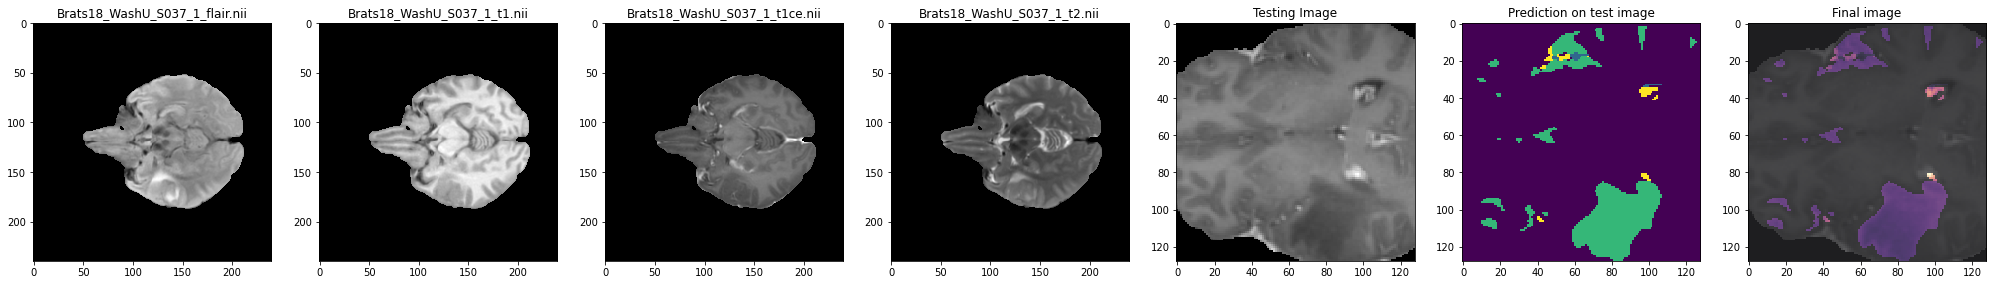

[Slide No] :55


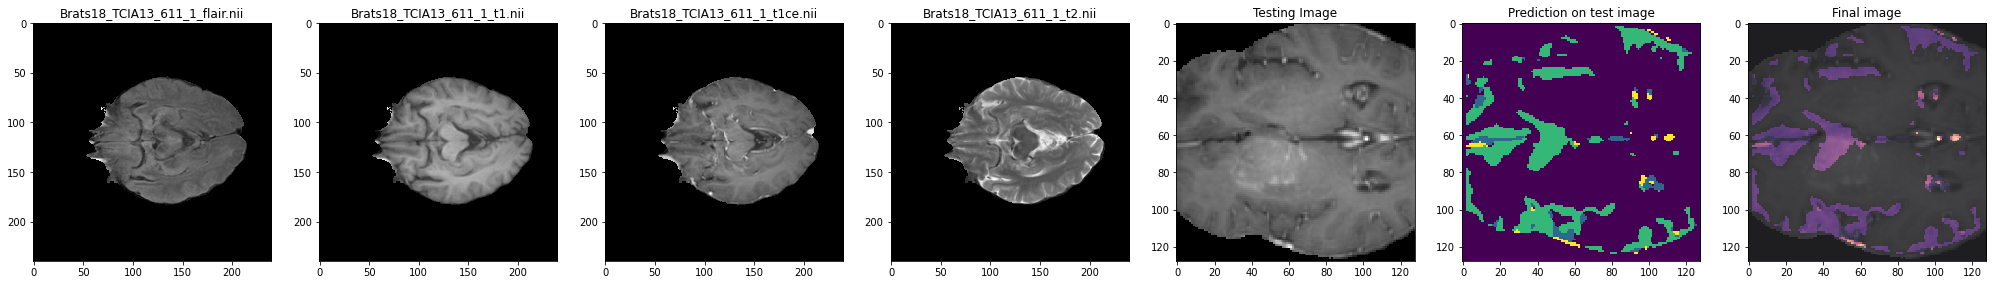

[Slide No] :55


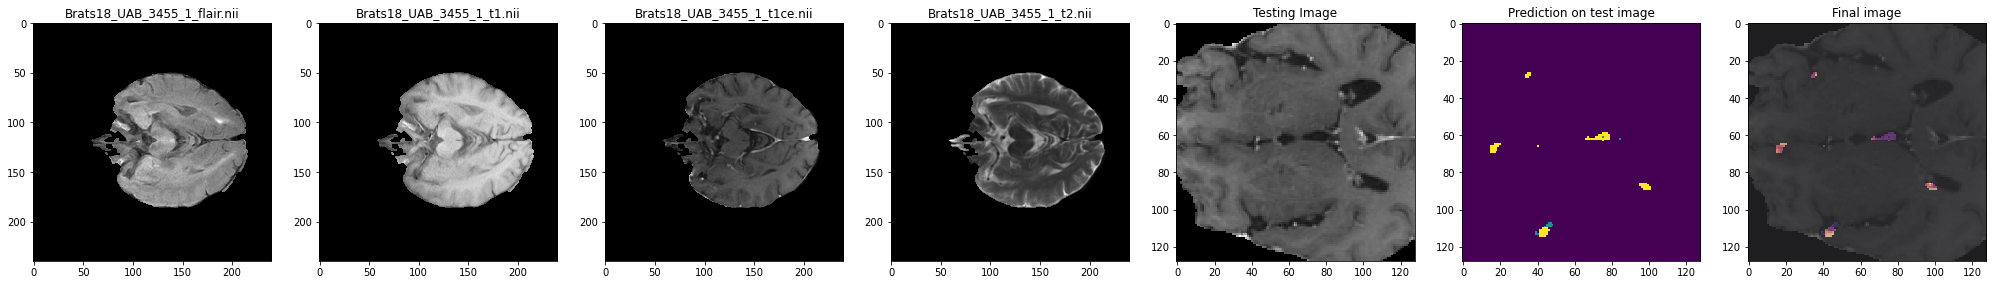

[Slide No] :55


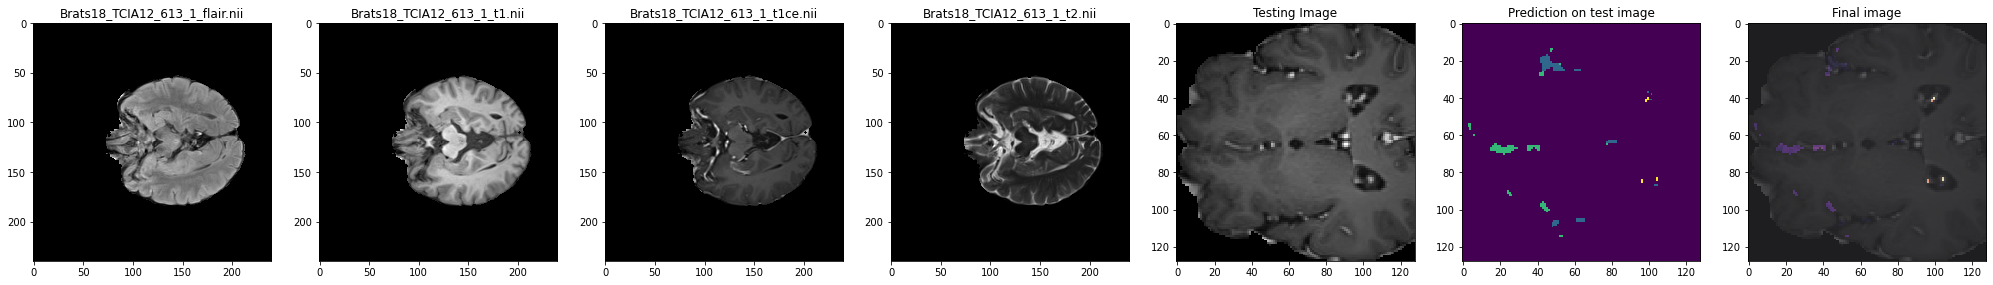

[Slide No] :55


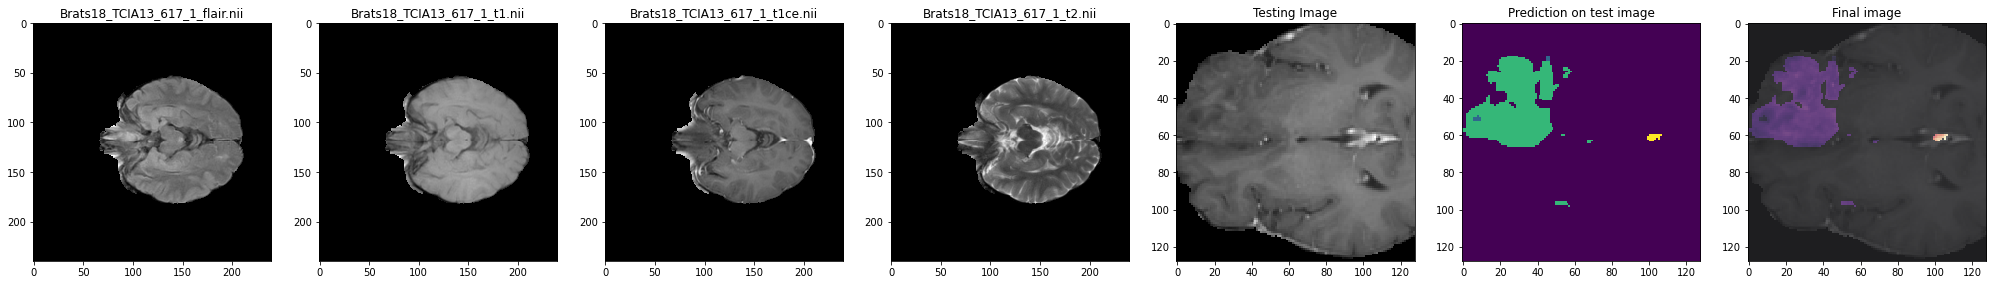

[Slide No] :55


In [ ]:
# pLotting from validation images dataset

for i in range(0,5):

  img = random.randint(0,len(val_t2_list))

  temp_image_t2=nib.load(val_t2_list[img]).get_fdata()
  temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
  temp_image_t1ce=nib.load(val_t1ce_list[img]).get_fdata()
  temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
  temp_image_flair=nib.load(val_flair_list[img]).get_fdata()
  temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

  temp_image_t1 = nib.load(val_t1_list[img]).get_fdata()
  temp_image_t1=scaler.fit_transform(temp_image_t1.reshape(-1, temp_image_t1.shape[-1])).reshape(temp_image_t1.shape)
  temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2,temp_image_t1], axis=3)
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
  test_img=temp_combined_images[56:184, 56:184, 13:141]

  test_img_input = np.expand_dims(test_img, axis=0)
  test_prediction = my_model.predict(test_img_input)
  test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

  from matplotlib import pyplot as plt
  import random

  n_slice = 55
  plt.figure(figsize=(35, 50))
  plt.subplot(1, 7, 1)  
  flair_name = val_flair_list[img].split('/')[5]  
  plt.title(f'{flair_name}')
  plt.imshow(temp_image_flair[:,:,n_slice],interpolation='none', cmap='gray')
  plt.subplot(1, 7, 2) 
  t1_name = val_t1_list[img].split('/')[5] 
  plt.title(f'{t1_name}')
  plt.imshow(temp_image_t1[:,:,n_slice],interpolation='none', cmap='gray')
  plt.subplot(1, 7, 3)  
  t1ce_name = val_t1ce_list[img].split('/')[5]
  plt.title(f'{t1ce_name}')
  plt.imshow(temp_image_t1ce[:,:,n_slice],interpolation='none', cmap='gray')
  plt.subplot(1, 7, 4)
  t2_name = val_t2_list[img].split('/')[5]  
  plt.title(f'{t2_name}')
  plt.imshow(temp_image_t2[:,:,n_slice],interpolation='none', cmap='gray')
  plt.subplot(1, 7, 5)  
  plt.title('Testing Image')
  plt.imshow(test_img[:,:,n_slice,1],interpolation='none', cmap='gray')
  plt.subplot(1, 7, 6)
  plt.title('Prediction on test image')
  plt.imshow(test_prediction_argmax[:,:, n_slice],interpolation='none')
  plt.subplot(1, 7, 7)
  plt.title('Final image')
  plt.imshow( test_img[:,:,n_slice,1] ,interpolation='none',cmap="gray",alpha=0.7)
  plt.imshow(test_img[:,:,n_slice,1]*test_prediction_argmax[:,:, n_slice],interpolation='none',cmap="magma",alpha=0.6)
  plt.show()
  print("[Slide No] :"+str(n_slice))

https://stackoverflow.com/questions/48121916/numpy-resize-rescale-image